# Drug Discovery via Generative Model

## 1. Introduction - Overview of problem and approach

Coronavirus is quickly becoming a global public health problem, threatening more and more people every day. Since the outbreak, many researchers have been interacting, collaborating and working very hard to stop the spread of the disease and to propose possible treatment plans.

New advances in machine intelligence have introduced algorithms that can learn important patterns from vast amounts of data, approaching expert-level of ability in some tasks.

Tasks -

1. Outline of the problem and introduction

2. Background and visualization - examination of the protein target with a bound ligand and its interactions.

3. Construction of a dataset with know bio-activites against similar proteins.

4. Generative deep learning model using a "Constrained Graph Variational Autoencoder", descibed here in https://arxiv.org/pdf/1805.09076.pdf. 

6. Promising compounds were then docked to the protein target using conventional molecular docking software (Autodock Vina) to return energy scores, suggesting if they may be important drug candidates.

7. Highest scoring candidates are reported

## 2. Disease and Background - Visualizing the Target

Covid-19 is the respiratory illness caused by the SARS 2 Coronavirus, it was unseen before in humans and rapid genetic data collection has shed some light into the origins. The genomes of several isolates of the virus are available, it is a ~30kB genome and can be found here: https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.

A crystal structure of the main protease of the virus was obtained by Liu et al., found at https://www.rcsb.org/structure/6LU7. The structure is complexed with a ligand called N3, which serves as an excellent starting point for new drug candidate investigations. The structure is visualized below using PyMol, which is excellent molecular visualization software available here: https://pymol.org/2/ or https://github.com/schrodinger/pymol-open-source.

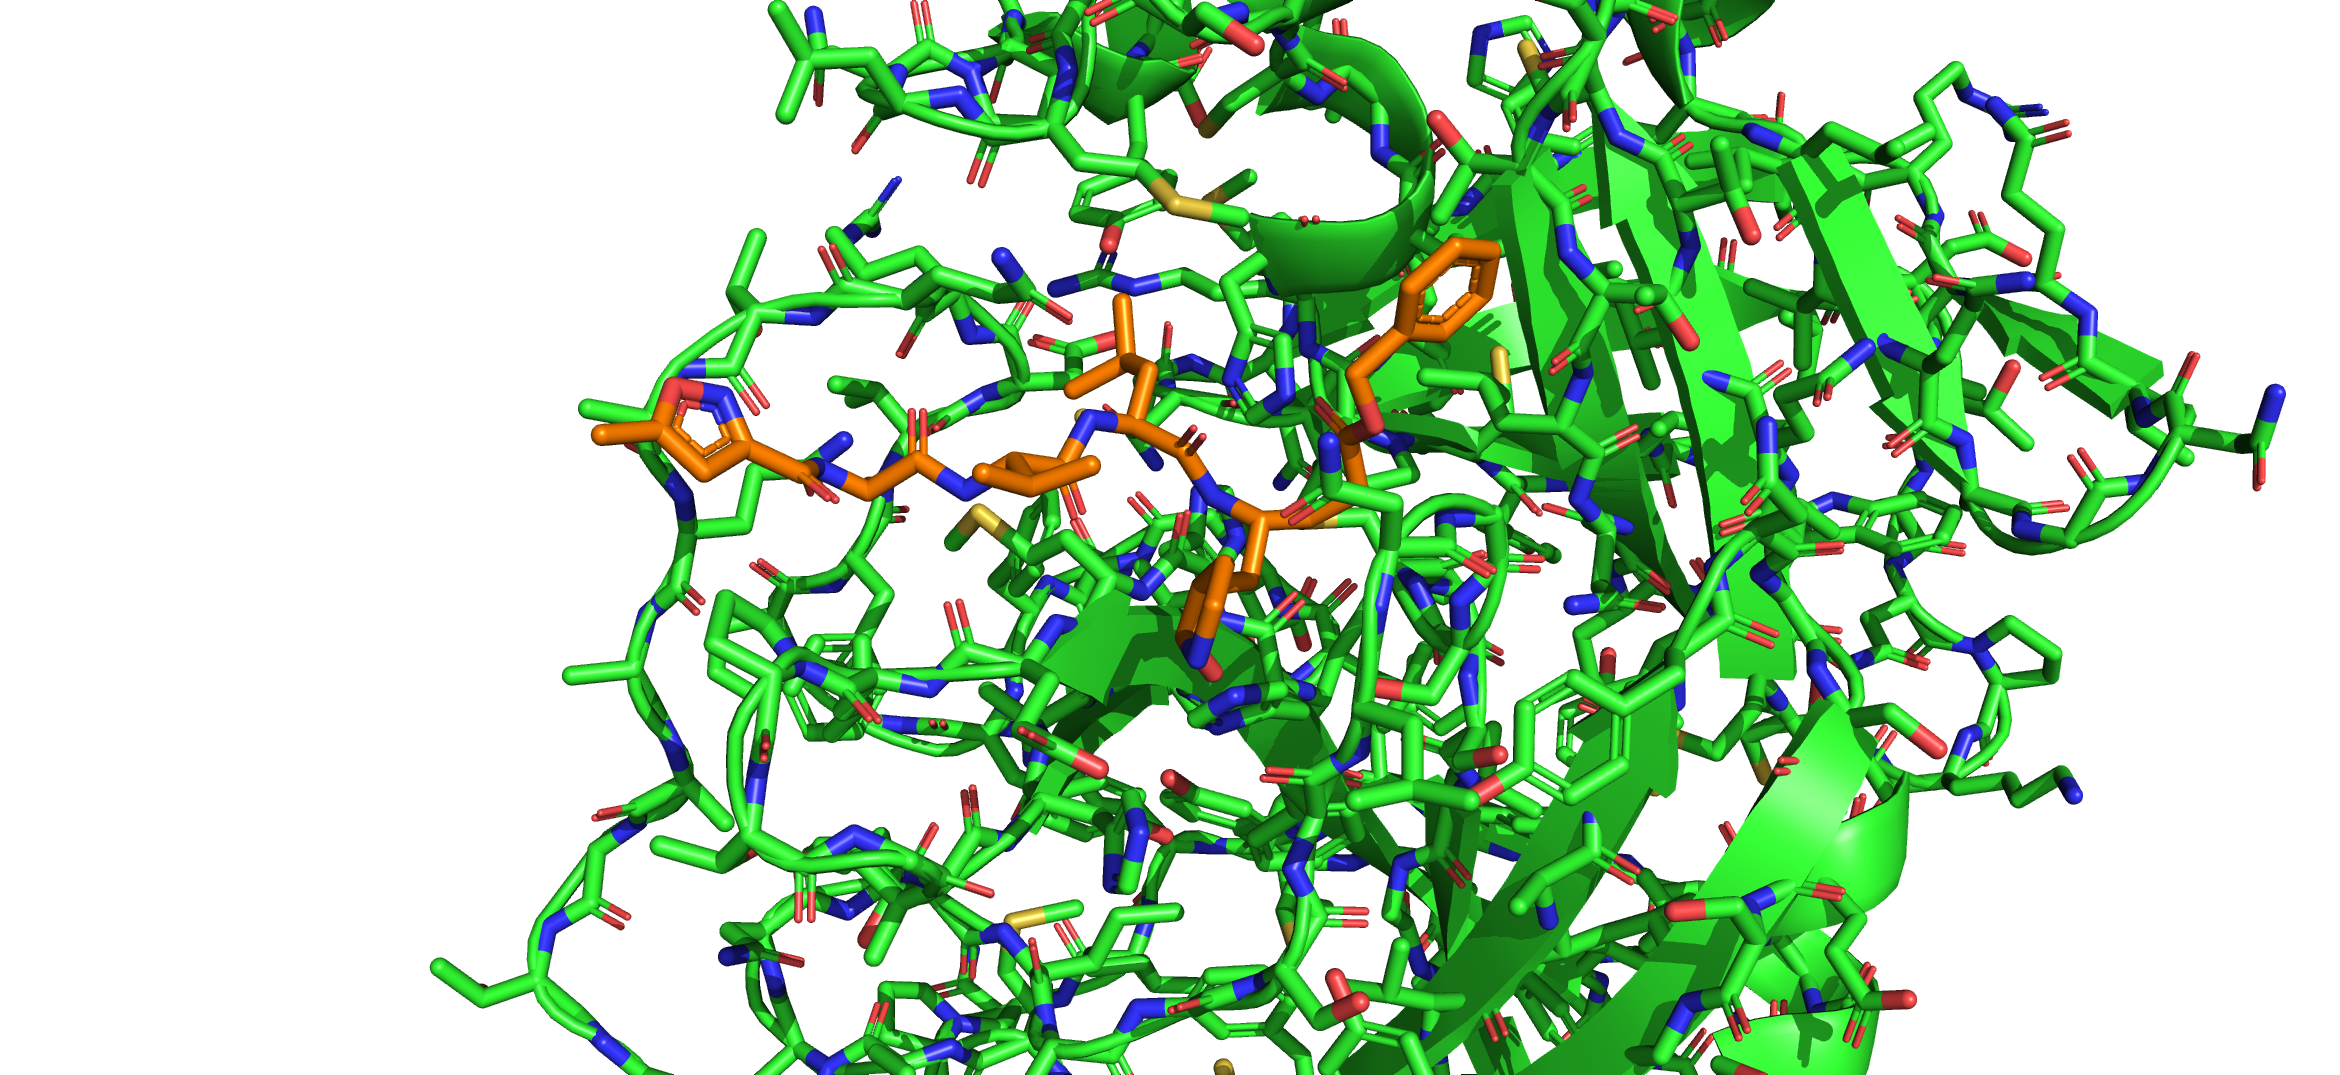

The following photo shows the interactions happening in the binding site between the N3 ligand and the protein, with yellow interactions being Hydrogen Bonds, and Red interactions being sites where hydrogen bonds could be possible, but are not occurring in the structure. It is also worth mentioning that the ligand shown here is what is called a "covalent inhibitor" meaning it is chemically bound to the protein. This can be seen on the right side of the orange ligand molecule, where it is connected to the yellow sulfur atom of the protein.

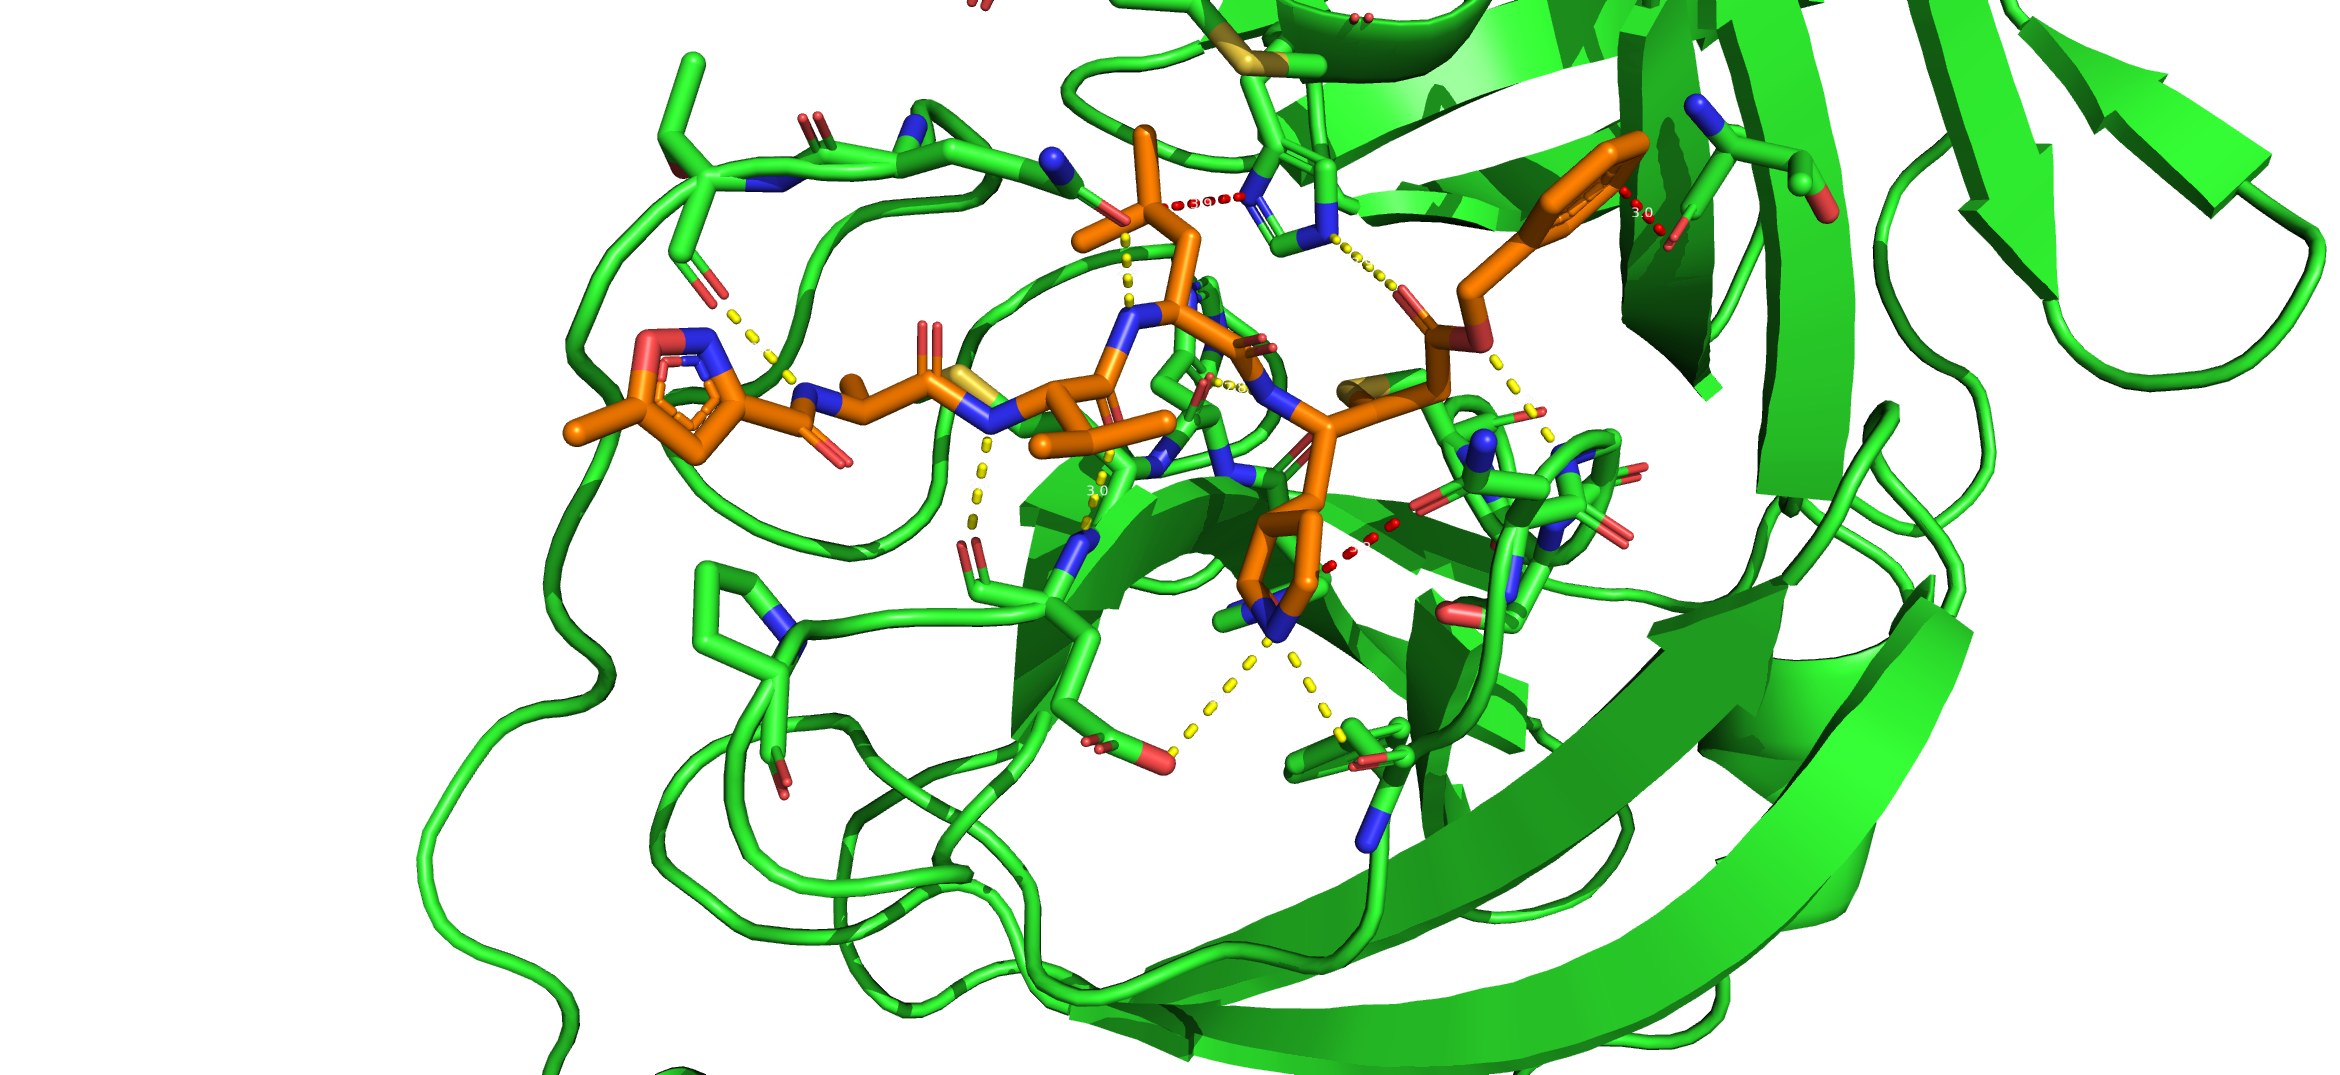

## 3. Dataset - Finding relevant compounds with activities

Machine learning methods tend to work better the more data you have, and with this new virus popping up, data is a bit harder to come by. However, we do know a lot about how viruses work and relying on a main protease is common between many viruses. Available anti-viral drugs often target their proteases. 

SARS and MERS are both coronavirus variants that are very similar and since their respective outbreaks, many biological assays have been done to test compounds on their main proteases. Bioactivities measured in papers by medicinal chemists and biochemists are tracked by The National Center for Biotechnology Information (NCBI) and are freely available. A database of protease inhibitors will be built using this data.

### General Dataset Preparation

The dataset generation begins by simply seaching the NCBI website, bioassay search found at https://www.ncbi.nlm.nih.gov/pcassay/advanced, to try and find relevant assays. Results from any search can be "sent to" a file (Shown below)

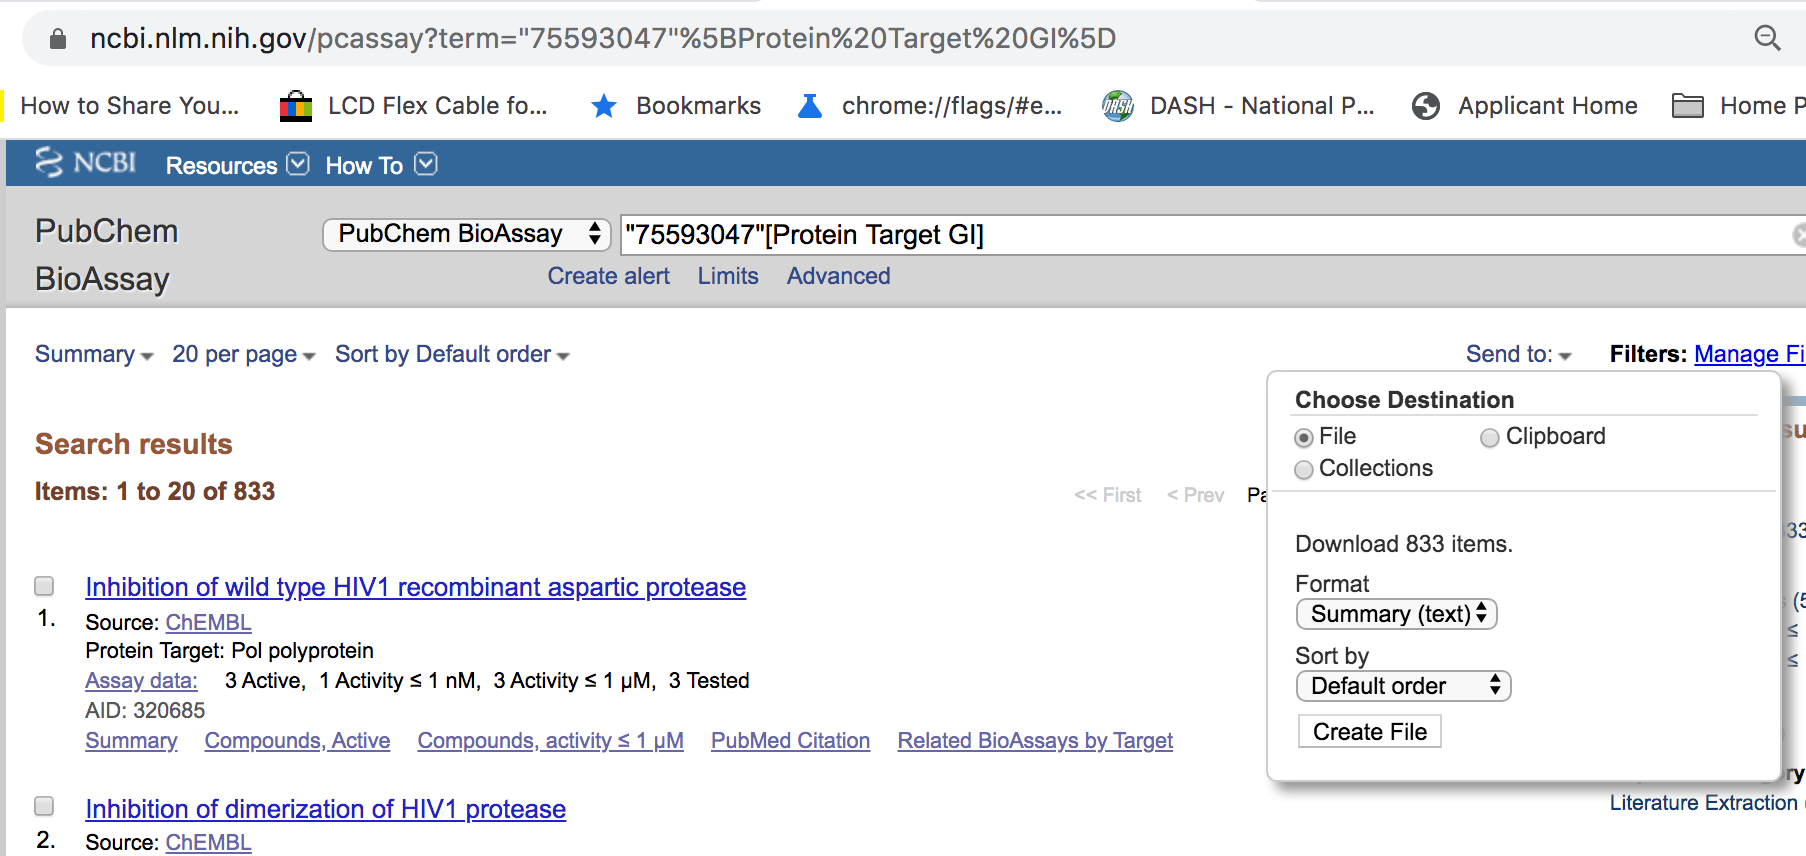

which contain ALL of the info for each result, then running the following commands to extra only the assay ID's of the results

In [10]:
! grep AID Data/SARS_C3_Assays.txt > Data/SARS_C3_Assays_AID_only.csv

In [11]:
! sed -i 's/[^0-9]//g' Data/SARS_C3_Assays_AID_only.csv

Note that each of these needs to be run for each of the search results and gives a list of assay ID's, or AIDs.

The searches We used to generate a good AID list are:

1. Protein target GI73745819 - SARS Protease - Called SARS_C3_Assays.txt in this report

2. Protein target GI75593047 - HIV pol polyprotein - Called HIV_Protease_Assays.txt in this report

3. NS3 - Hep3 protease - Called NS3_Protease_Assays.txt in this report

4. 3CL-Pro - Mers Protease - Called MERS_Protease_Assays.txt in this report

The actual compound activity data will be downloaded from NCBI using their system called "PUG-REST" which are specifically designed URLs that let you download raw info of various NCBI records.

WARNING: This can take a really long time since it has to do a wget on EVERY compound.

In [29]:
#Imports
import rdkit
from rdkit.Chem import AllChem as Chem
import numpy as np
import pandas as pd
import os
import time
import pickle
import csv
from rdkit.Chem import QED
import random
import json

In [62]:
def get_assays(assay_path, assay_pickle_path):
    with open(str(assay_path)) as f:
        r = csv.reader(f)
        AIDs = list(r)
    assays = []
    for i, AID in zip(range(len(AIDs)), AIDs):
        os.system(f'wget https://pubchem.ncbi.nlm.nih.gov/rest/pug/assay/aid/{str(AID[0])}/csv -O Data/assay.csv')
        if os.stat(f'Data/assay.csv').st_size != 0:
            assays.append(pd.read_csv(f'Data/assay.csv'))

    pickle.dump(assays, open(str(assay_pickle_path), "wb"))

def get_mols_for_assays(assays_no_mol_path, assays_with_mol_path):
    assays = pickle.load(open(str(assays_no_mol_path), "rb"))
    for assay in assays:
        if len(assay) != 1:
            cids = list(assay[['PUBCHEM_CID']].values.astype("int32").squeeze())
            nan_counter = 0
            for i in range(len(cids)):
                if cids[i] < 0:
                    nan_counter += 1
                else:
                    break
            cids = cids[nan_counter:]
            mols = []
            for CID in cids:
                os.system('wget https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%s/sdf -O cmp.sdf' %CID)
                if os.stat(f'Data/cmp.sdf').st_size != 0:
                    mols.append(Chem.SDMolSupplier("Data/cmp.sdf")[0])
                else:
                    mols.append(None)

            for i in range(nan_counter):
                mols.insert(0,None)

            assay.insert(3, "Mol Object", mols)

    pickle.dump(assays, open(str(assays_with_mol_path), "wb"))

In [63]:
get_assays("Data/SARS_C3_Assays_AID_only.csv", "Data/sars/sars_assays_no_mol.pkl")

In [64]:
get_mols_for_assays("Data/sars/sars_assays_no_mol.pkl", "Data/sars/sars_assays.pkl")

In [ ]:
#This goes an HTTP get on EVERY compound and takes a WHILE. Might be better to just use the pickled datasets
get_assays_no_mol("Data/MERS_Protease_Assays_AID_only.csv", "Data/mers/mers_assays_no_mol.pkl")
get_mols_for_assay("Data/mers/mers_assays_no_mol.pkl", "Data/mers/mers_assays.pkl")
get_assays_no_mol("Data/NS3_Protease_Assays_AID_only.csv", "Data/ns3/ns3_assays_no_mol.pkl")
get_mols_for_assay("Data/ns3/ns3_assays_no_mol.pkl", "Data/ns3/ns3_assays.pkl")
get_assays_no_mol("Data/HIV_Protease_Assays_AID_only.csv", "Data/hiv/hiv_assays_no_mol.pkl")
get_mols_for_assay("Data/hiv/hiv_assays_no_mol.pkl", "Data/hiv/hiv_assays.pkl")

In [69]:
#This datastructure is a dictionary of lists of dataframe. 
assays = {}
assays["sars"] = pickle.load(open("Data/sars/sars_assays.pkl", "rb"))
assays["mers"] = pickle.load(open("Data/mers/mers_assays.pkl", "rb"))
assays["ns3"] = pickle.load(open("Data/ns3/ns3_assays.pkl", "rb"))
assays["hiv"] = pickle.load(open("Data/hiv/hiv_assays.pkl", "rb"))

For this report we will focus on the "PubChem Standard Value" which is normally a standardized value using some metric (we will further narrow to only the metrics we want)

In [70]:
#This removes all the assays that do not have a column called "PubChem Standard Value"
for a in ["sars", "mers", "ns3", "hiv"]:
    print("Length of",str(a),"before removing")
    print(len(assays[a]))
    assays[a] = np.array(assays[a])
    bad_list = []
    good_list = []
    for i in range(len(assays[a])):
        ic50_cols = [col for col in assays[a][i].columns if 'PubChem Standard Value' in col]
        if not ic50_cols:
            bad_list.append(i)
        else:
            good_list.append(int(i))

    bad_list = np.array(bad_list)
    good_list = np.array(good_list, dtype='int32')

    assays[a] = assays[a][good_list]
    print("Length of",str(a),"after removing")
    print(len(assays[a]))

Length of sars before removing
13
Length of sars after removing
0
Length of mers before removing
7
Length of mers after removing
4
Length of ns3 before removing
3252
Length of ns3 after removing
1305
Length of hiv before removing
582
Length of hiv after removing
580


In [71]:
#Remove unnesessary columns
for a in ["sars", "mers", "ns3", "hiv"]:
    for i in range(len(assays[a])):
        assays[a][i] = assays[a][i][["Mol Object", "PubChem Standard Value", "Standard Type"]]

In [72]:
#Look at what different kind of metrics were used
for a in ["sars", "mers", "ns3", "hiv"]:
    for i in range(len(assays[a])):
        print(assays[a][i][["Standard Type"]].values[-1])

['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['Ki']
['Ki']
['Ki']
['Ki']
['Ki']
['Ki']
['Ki']
['Ki']
['Ki']
['Ki']
['Ki']
['EC50']
['IC50']
['IC50']
['Cmax']
['EC50']
['EC50']
['EC50']
['CC50']
['IC50']
['IC50']
['Ki']
['Ki']
['IC50']
['IC50']
['Kd']
['Ki']
['IC50']
['Ki']
['Ki']
['IC50']
['Ki']
['IC50']
['EC50']
['EC50']
['IC50']
['IC50']
['IC50']
['IC50']
['FC']
['FC']
['FC']
['Ki']
['Ki']
['Ki']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['Km']
['Km']
['Km']
['IC50']
['IC50']
['Activity']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['Ki']
['IC50']
['IC50']
['EC50']
['EC50']
['IC50']
['Ki']
['Ki']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['EC50']
['E

['EC50']
['IC50']
['IC50']
['IC50']
['IC50']
['Ki']
['Ki']
['IC50']
['IC50']
['Kd']
['Ki']
['EC90']
['EC50']
['EC50']
['EC90']
['EC90']
['EC50']
['Ki']
['Ki']
['Kcat']
['IC50']
['IC50']
['EC90']
['EC90']
['Ki']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['Ki']
['CC50']
['IC50']
['IC50']
['IC50']
['Inhibition']
['MIC']
['IC50']
['IC50']
['Inhibition']
['EC50']
['EC50']
['CC50']
['EC50']
['Solubility']
['EC50']
['Drug uptake']
['Drug uptake']
['Cp']
['Cp']
['Cp']
['CC50']
['Cp']
['Cp']
['EC50']
['IC90']
['EC50']
['CC50']
['Ki']
['CC50']
['EC50']
['EC50']
['EC50']
['CC50']
['EC50']
['EC50']
['CC50']
['EC90']
['IC99']
['EC90']
['IC50']
['IC50']
['IC50']
['IC50']
['CC50']
['Inhibition']
['EC50']
['EC50']
['CC50']
['IC50']
['CC50']
['Kd']
['EC50']
['permeability']
['CC50']
['IC50']
['Ki']
['IC50']
['Ki']
['Kd']
['Kd']
['Kd']
['Kd']
['Kd']
['Kd']
['IC50']
['Kd']
['IC50']
['Kd']
['IC50']
['IC50']
['EC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['IC50']
['Kd']
['IC50']
['IC50']

In [73]:
#concatenate all of the dataframe in the dictionary into a single list.
#We lose the notion that they were once for different targets
all_dfs = []
for a in ["sars", "mers", "ns3", "hiv"]:
    for i in range(len(assays[a])):
        if assays[a][i][["Standard Type"]].values[-1][0] in {"IC50", "Ki", "Kd", "IC90"}:
            all_dfs.append(assays[a][i])

In [74]:
#Remove header info and concatenate them
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i].iloc[4:]
final_df = pd.concat(all_dfs)

In [75]:
#Take only the compounds with activites below 0.1 (all will be relatively active)
final_df['PubChem Standard Value'] = final_df['PubChem Standard Value'].astype(float)
df = final_df[final_df["PubChem Standard Value"] < 0.1]

In [ ]:
pickle.dump(df, open("Data/final_df.pkl", "wb"))

## 4. Preprocessing of Data

In [99]:
df = pickle.load(open("Data/final_df.pkl", "rb"))

In [100]:
df.insert(3, 'smiles', [Chem.MolToSmiles(x) for x in df[['Mol Object']].values[:,0]], True)
df.insert(4, 'qed', [QED.qed(x) for x in df[['Mol Object']].values[:,0]], True)

In [101]:
salt_indexes = []
for i in range(len(df)):
    if "." in df[["smiles"]].values[i][0]:
        salt_indexes.append(i)

In [102]:
df = df.reset_index()
df = df.drop(df.index[salt_indexes])


df[["smiles", "qed"]].to_csv("Data/250k_rndm_drugs_clean_3.csv", index=False)
new_valid_idx = random.sample(range(len(df)), int(len(df)*0.1))
new_valid_idx.sort()
with open("Data/valid_idx.json", 'w') as f:
    json.dump(new_valid_idx, f)